In [27]:
import os
import matplotlib.pyplot as plt
import SimpleITK as sitk

from glob import glob

import numpy as np

from scipy.ndimage import shift

import cv2

In [50]:
template_mask = sitk.GetArrayFromImage(sitk.ReadImage("template_normal_mask.nii.gz"))

base_dir = "/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test"
input_paths = glob(os.path.join(base_dir, "*", "*_SA.nii.gz"))


# template_mask = sitk.GetArrayFromImage(sitk.ReadImage("tmp.nii.gz"))

# base_dir = "/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test"
# input_paths = glob(os.path.join(base_dir, "*", "*scaled.nii.gz"))
print(input_paths)


imgs = []
for path in input_paths:
    img = sitk.GetArrayFromImage(sitk.ReadImage(path))
    # 只取第一张 非门控图
    imgs.append(img[0])
    
input_img1, input_img2, input_img3, input_img4, input_img5 = imgs

print(template_mask.shape, input_img1.shape)

['/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test/001398670/270_SA.nii.gz', '/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test/002478508/460_SA.nii.gz', '/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test/002640212/1278_SA.nii.gz', '/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test/002657146/1787_SA.nii.gz', '/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test/000652515/161_SA.nii.gz']
(20, 17, 20) (20, 21, 20)


(0, 0, 2)


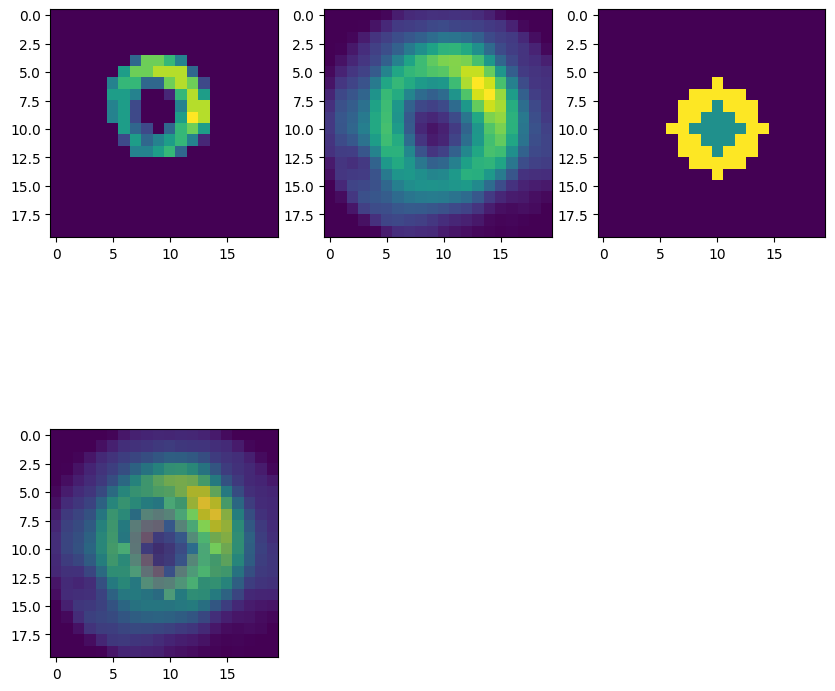

In [65]:
template_mask2d = template_mask[:,5:,:].sum(axis=1)
# template_mask2d = template_mask2d[10:41,14:43]

fig = plt.figure(figsize=(10,10))

plt.subplot(231)
plt.imshow(template_mask2d)


img2d = imgs[0][:, 5:,:].sum(axis=1)

plt.subplot(2,3, 2)


### 算法 开始
H, W = img2d.shape

plt.imshow(img2d)



# l = 5
# r_min, r_max = 5,20
l = 2
r_min, r_max = 2,4
def generate_ring_mask(shape, r_inner, r_outer):
    """
    生成一个环形 mask
    :param shape: (H, W) 图像尺寸
    :param r_inner: 内半径
    :param r_outer: 外半径
    :return: 环形 mask (H, W)
    """
    H, W = shape
    Y, X = np.ogrid[:H, :W]
    center = (H // 2, W // 2)  # 初始假设圆心在中心
    dist_sq = (X - center[1]) ** 2 + (Y - center[0]) ** 2
    
    mask = np.zeros(shape, dtype=np.float32)
    
    mask[dist_sq <= r_inner ** 2] = 1
    mask[(dist_sq <= r_outer ** 2) & (dist_sq > r_inner ** 2)] = 2
    
    return mask

# 预计算所有可能的环形 mask
ring_masks = {r: generate_ring_mask((H, W), r, r + l) for r in range(r_min, r_max - l)}
best_density = -np.inf
# 遍历所有可能的圆心
shift_px = 3
for i, dx in enumerate(range(-shift_px, shift_px + 1)):
    for j, dy in enumerate(range(-shift_px, shift_px + 1)):
        for r, mask in ring_masks.items():
            # 平移 mask 到当前圆心
            # shifted_mask = np.roll(np.roll(mask, cx - H // 2, axis=0), cy - W // 2, axis=1)
            shifted_mask = shift(mask, shift=(dy, dx), mode='constant', cval=0)
            
            area1 = np.sum(shifted_mask==1)
            area2 = np.sum(shifted_mask==2)
            
            # 计算圆环密度
            filt1 = shifted_mask==1
            density1 = np.sum(img2d[filt1] * shifted_mask[filt1]) / area1
            
            
            filt2 = shifted_mask==2
            density2 = np.sum(img2d[filt2] * shifted_mask[filt2]) / area2 / 2
            
            
            if density2/density1 > best_density:
                best_density = density2/density1
                
                best_circle = dx, dy, r

print(best_circle)

dx, dy, r = best_circle
best_mask = generate_ring_mask((H, W), r, r + l)
# shifted_mask = np.roll(np.roll(best_mask, cx - H // 2, axis=0), cy - W // 2, axis=1)
shifted_mask = shift(mask, shift=(dy, dx), mode='constant', cval=0)

plt.subplot(2,3,3)
plt.imshow(best_mask)


plt.subplot(2,3,4)

plt.imshow(img2d)
plt.imshow(shifted_mask, alpha=0.2)

    
    # img2d = cv2.normalize(img2d, None, 0, 255, cv2.NORM_MINMAX)
    # # print(np.min(img2d), np.max(img2d), np.mean(img2d))
    # img2d = img2d.astype(np.uint8)
    
    # circles = cv2.HoughCircles(img2d, cv2.HOUGH_GRADIENT, dp=2, minDist=100,
    #                        param1=40, param2=20, minRadius=5, maxRadius=30)

    # # 绘制检测结果
    # if circles is not None:
    #     circles = np.uint16(np.around(circles))
    #     output = cv2.cvtColor(img2d, cv2.COLOR_GRAY2BGR)  # 转换为彩色图像
    #     for circle in circles[0, :]:
    #         cx, cy, r = circle
    #         cv2.circle(output, (cx, cy), r, (0, 255, 0), 2)  # 画圆
    #         cv2.circle(output, (cx, cy), 2, (0, 0, 255), 3)  # 画圆心

    #     # 显示图像
    #     plt.imshow(output)
    #     plt.title(f"Detected {len(circles[0])} circles")
    #     plt.axis("off")
    #     # plt.show()
    # else:
    #     print("未检测到圆形")
    
    
    
    
    
    


In [ ]:
# import SimpleITK as sitk
# import numpy as np

# # 输入的3D心脏图像和二值mask
# heart_image = sitk.ReadImage("/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test/001398670/270_SA.nii.gz")
# heart_mask = sitk.ReadImage('tmp.nii.gz')

# # 配准的初始化参数
# initial_transform = sitk.Transform(3, sitk.sitkAffine)  # 使用仿射变换，包括缩放和平移

# # 配准过程
# def register_mask_to_image(heart_image, heart_mask):
#     # 使用SimpleITK的图像配准工具
#     registration_method = sitk.ImageRegistrationMethod()
    
#     # 设置损失函数：互信息
#     registration_method.SetMetricAsMattes(50)  # 50是直方图的bin数，可以根据需要调整
#     registration_method.SetMetricSamplingStrategy(sitk.ImageRegistrationMethod.SampleOptimized)
#     registration_method.SetInterpolator(sitk.sitkLinear)
    
#     # 设置优化器
#     registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=1.0, minStep=1e-6, numberOfIterations=100)
    
#     # 设置初始变换
#     registration_method.SetInitialTransform(initial_transform)
    
#     # 执行配准
#     final_transform = registration_method.Execute(heart_mask, heart_image)
    
#     # 使用最终的变换应用到心脏mask
#     resampled_mask = sitk.Resample(heart_mask, heart_image, final_transform, sitk.sitkLinear, 0.0, heart_mask.GetSize())
    
#     return resampled_mask

# # 执行配准
# registered_mask = register_mask_to_image(heart_image, heart_mask)

# # 保存配准后的mask
# sitk.WriteImage(registered_mask, 'registered_heart_mask.nii')


AttributeError: 'ImageRegistrationMethod' object has no attribute 'SetMetricAsMattes'

In [ ]:
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from IPython.display import clear_output

# 输出目录
OUTPUT_DIR = 'Output'

# 输入的3D心脏图像和二值mask
heart_image = sitk.ReadImage("/mnt/labnas/DataCollection/Project/RadiSmart/cardiac/demo_test/001398670/270_SA.nii.gz")
heart_mask = sitk.ReadImage('tmp.nii.gz')

# 可视化图像
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    plt.subplots(1, 2, figsize=(10, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(fixed_npa[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title('Fixed Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(moving_npa[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title('Moving Image')
    plt.axis('off')

    plt.show()

interact(display_images, 
         fixed_image_z=(0, heart_image.GetSize()[2]-1),
         moving_image_z=(0, heart_mask.GetSize()[2]-1), 
         fixed_npa=fixed(sitk.GetArrayViewFromImage(heart_image)),
         moving_npa=fixed(sitk.GetArrayViewFromImage(heart_mask)))

# 初始化变换
initial_transform = sitk.CenteredTransformInitializer(
    heart_image, 
    heart_mask, 
    sitk.Euler3DTransform(), 
    sitk.CenteredTransformInitializerFilter.GEOMETRY
)

# 配准方法设置
registration_method = sitk.ImageRegistrationMethod()

# 互信息度量设置
registration_method.SetMetricAsMattesMutualInformation(50)  # 设置直方图的bin数
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# 优化器设置
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0, 
    numberOfIterations=100, 
    convergenceMinimumValue=1e-6, 
    convergenceWindowSize=10
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# 多分辨率设置
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# 设置初始变换
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# 配准回调函数
def start_plot():
    global metric_values, multires_iterations
    metric_values = []
    multires_iterations = []

def end_plot():
    global metric_values, multires_iterations
    del metric_values
    del multires_iterations
    plt.close()

def plot_values(registration_method):
    global metric_values, multires_iterations
    metric_values.append(registration_method.GetMetricValue())
    clear_output(wait=True)
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number', fontsize=12)
    plt.ylabel('Metric Value', fontsize=12)
    plt.show()

def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

# 配准执行
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(heart_image, sitk.sitkFloat32),
                                              sitk.Cast(heart_mask, sitk.sitkFloat32))

# 输出最终配准结果
print(f"Final metric value: {registration_method.GetMetricValue()}")
print(f"Stopping condition: {registration_method.GetOptimizerStopConditionDescription()}")

# 应用最终变换并保存
heart_mask_resampled = sitk.Resample(heart_mask, heart_image, final_transform, sitk.sitkLinear, 0.0, heart_mask.GetPixelID())
sitk.WriteImage(heart_mask_resampled, os.path.join(OUTPUT_DIR, 'registered_heart_mask.nii'))
sitk.WriteTransform(final_transform, os.path.join(OUTPUT_DIR, 'final_transform.tfm'))

# 可视化配准后的结果
interact(display_images_with_alpha, 
         image_z=(0, heart_image.GetSize()[2]), 
         alpha=(0.0, 1.0, 0.05), 
         fixed=fixed(heart_image), 
         moving=fixed(heart_mask_resampled))


NameError: name 'interact' is not defined